In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/regression_image_dataset.zip'  # Replace with actual zip path
extract_path = '/content/dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
# Step 3: Set Paths
image_folder = '/content/dataset/images'  # change this path
csv_file = '/content/dataset/labels.csv'  # change this path

In [4]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
# Step 4: Load CSV and filter out 'undipped' (-1.0) rows
df = pd.read_csv(csv_file)
df = df[df['label'] != -1.0].reset_index(drop=True)  # Filter out label = -1.0

# Step 5: Load Images and Labels
image_size = (224, 224)
X, y = [], []

for index, row in df.iterrows():
    img_path = os.path.join(image_folder, row['filename'])  # column should be named 'filename'
    label = row['label']
    if os.path.exists(img_path):
        image = load_img(img_path, target_size=image_size)
        image = img_to_array(image) / 255.0
        X.append(image)
        y.append(label)

X = np.array(X)
y = np.array(y)


In [5]:
# STEP 5: Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

Train set: (1728, 224, 224, 3) (1728,)
Validation set: (432, 224, 224, 3) (432,)


In [7]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from xgboost import XGBRegressor
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.2 MB/s eta 0:00:00


In [8]:
# Loading my pretrained base models

resnet_model = load_model("resnet_trained.h5", compile=False)
mobilenet_model = load_model("mobilenet_trained.h5", compile=False)
densenet_model = load_model("densenet_trained.h5", compile=False)

print("All pretrained models loaded successfully!")

All pretrained models loaded successfully!


In [9]:
# Converting base models to embedding extractors

resnet_embedder = Model(
    inputs=resnet_model.input,
    outputs=resnet_model.layers[-2].output
)

mobilenet_embedder = Model(
    inputs=mobilenet_model.input,
    outputs=mobilenet_model.layers[-2].output
)

densenet_embedder = Model(
    inputs=densenet_model.input,
    outputs=densenet_model.layers[-2].output
)

In [10]:
# Generating embeddings for train and validation
train_res = resnet_embedder.predict(X_train, batch_size=32, verbose=1)
train_mob = mobilenet_embedder.predict(X_train, batch_size=32, verbose=1)
train_den = densenet_embedder.predict(X_train, batch_size=32, verbose=1)

val_res = resnet_embedder.predict(X_val, batch_size=32, verbose=1)
val_mob = mobilenet_embedder.predict(X_val, batch_size=32, verbose=1)
val_den = densenet_embedder.predict(X_val, batch_size=32, verbose=1)

print("Embedding Shapes:")
print(train_res.shape, train_mob.shape, train_den.shape)

54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 116ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 472ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 897ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step
Embedding Shapes:
(1728, 128) (1728, 128) (1728, 128)


In [11]:
# Combining embeddings
X_train_stack = np.concatenate([train_res, train_mob, train_den], axis=1)
X_val_stack   = np.concatenate([val_res, val_mob, val_den], axis=1)

print("Stacked Train Shape:", X_train_stack.shape)
print("Stacked Val Shape:", X_val_stack.shape)

Stacked Train Shape: (1728, 384)
Stacked Val Shape: (432, 384)


In [12]:
# Meta Learner 1 - XGBoost
xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=2,
    reg_lambda=2,
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist"
)

print("Training XGBoost...")
xgb.fit(X_train_stack, y_train)

pred_xgb_train = xgb.predict(X_train_stack)
pred_xgb_val   = xgb.predict(X_val_stack)

Training XGBoost...


In [13]:
# Meta Learner 2 - CATBoost
cat = CatBoostRegressor(
    iterations=800,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=2,
    random_seed=42,
    loss_function="RMSE",
    verbose=False
)

print("Training CatBoost...")
cat.fit(X_train_stack, y_train)

pred_cat_train = cat.predict(X_train_stack)
pred_cat_val   = cat.predict(X_val_stack)

Training CatBoost...


In [14]:
# Final Blender - Ridge Regression
stack_train = np.vstack([pred_xgb_train, pred_cat_train]).T
stack_val   = np.vstack([pred_xgb_val, pred_cat_val]).T

ridge = Ridge(alpha=1.0)
ridge.fit(stack_train, y_train)

final_pred = ridge.predict(stack_val)

In [15]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(name, y_true, y_pred):
    r2   = r2_score(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    print(f"\n{name} Performance:")
    print(f"R²   : {r2:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"MSE  : {mse:.4f}")
    print(f"RMSE : {rmse:.4f}")

# Evaluate each model using validation set
evaluate_model("XGBoost", y_val, pred_xgb_val)
evaluate_model("CatBoost", y_val, pred_cat_val)
evaluate_model("Ridge-Blended Final Model", y_val, final_pred)


XGBoost Performance:
R²   : 0.9763
MAE  : 0.4137
MSE  : 0.3624
RMSE : 0.6020

CatBoost Performance:
R²   : 0.9786
MAE  : 0.4168
MSE  : 0.3276
RMSE : 0.5723

Ridge-Blended Final Model Performance:
R²   : 0.9769
MAE  : 0.4112
MSE  : 0.3532
RMSE : 0.5943


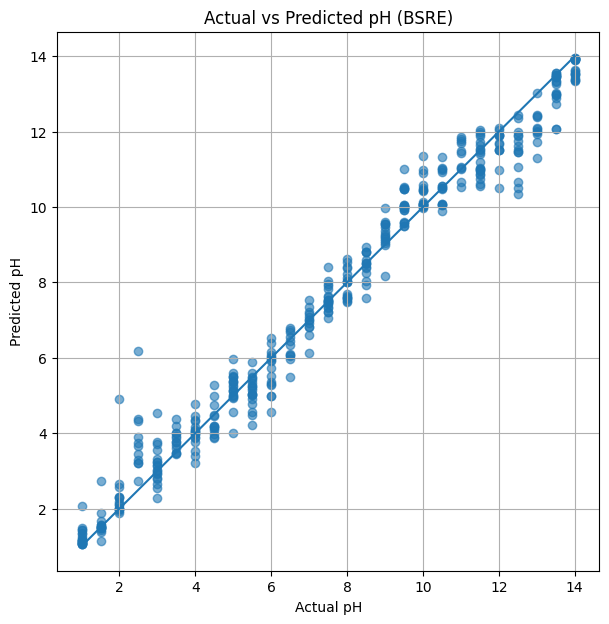

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(y_val, final_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()])
plt.xlabel("Actual pH")
plt.ylabel("Predicted pH")
plt.title("Actual vs Predicted pH (BSRE)")
plt.grid(True)
plt.savefig("bsre_actual_vs_predicted_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

In [17]:
import pandas as pd
from google.colab import files

# STEP 8: Save predicted vs actual for inspection
results = pd.DataFrame({'Actual pH': y_val, 'Predicted pH': final_pred.flatten()})

# Save locally in Colab
csv_path = '/content/BSRE_pH_predictions.csv'
results.to_csv(csv_path, index=False)

# Trigger download
files.download(csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
import pandas as pd
from google.colab import files

# STEP 8: Save predicted vs actual for inspection
results = pd.DataFrame({'Actual pH': y_val, 'Predicted pH': pred_xgb_val.flatten()})

# Save locally in Colab
csv_path = '/content/XGB_pH_predictions.csv'
results.to_csv(csv_path, index=False)

# Trigger download
files.download(csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
import pandas as pd
from google.colab import files

# STEP 8: Save predicted vs actual for inspection
results = pd.DataFrame({'Actual pH': y_val, 'Predicted pH': pred_cat_val.flatten()})

# Save locally in Colab
csv_path = '/content/CAT_pH_predictions.csv'
results.to_csv(csv_path, index=False)

# Trigger download
files.download(csv_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

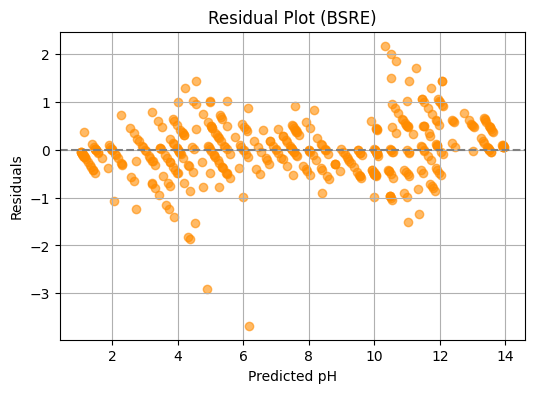

In [19]:
residuals = y_val - final_pred

plt.figure(figsize=(6,4))
plt.scatter(final_pred, residuals, alpha=0.6, color='darkorange')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Predicted pH")
plt.ylabel("Residuals")
plt.title("Residual Plot (BSRE)")
plt.grid(True)
plt.savefig("BSRE_residual_plot.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

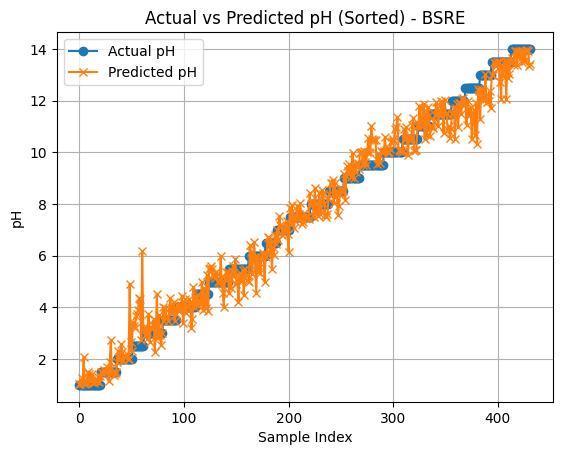

In [20]:
import numpy as np

sorted_indices = np.argsort(y_val)
plt.plot(np.array(y_val)[sorted_indices], label='Actual pH', marker='o')
plt.plot(final_pred[sorted_indices], label='Predicted pH', marker='x')
plt.title("Actual vs Predicted pH (Sorted) - BSRE")
plt.xlabel("Sample Index")
plt.ylabel("pH")
plt.legend()
plt.grid(True)
plt.savefig("BSRE_actualvspredicte_sorted.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

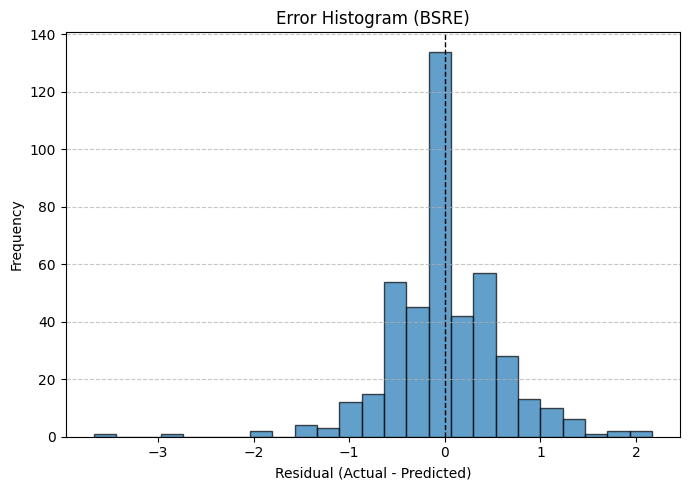

In [21]:
import matplotlib.pyplot as plt

# Residuals (errors)
residuals = y_val - final_pred

# Error histogram
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=25, edgecolor='black', alpha=0.7)
plt.axvline(0, color='k', linestyle='--', linewidth=1)  # reference line at 0
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Error Histogram (BSRE)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("BSRE_error_histogram.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

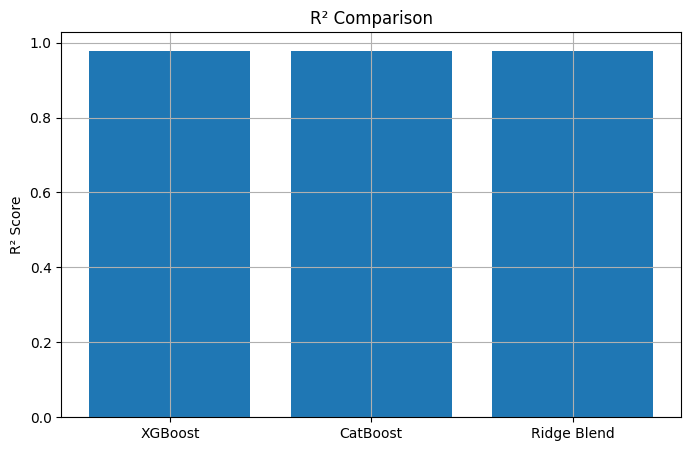

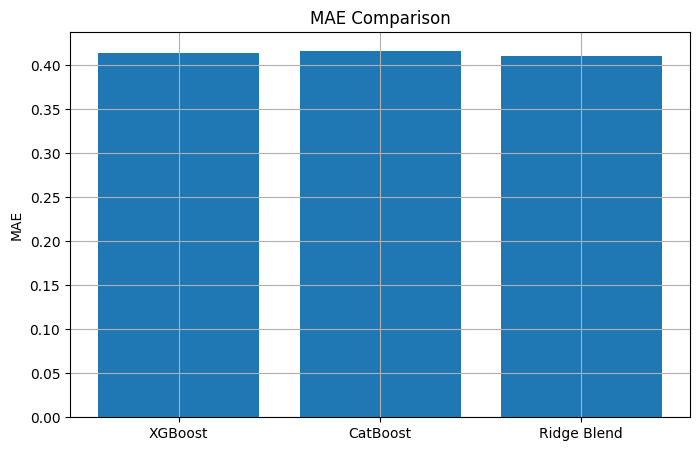

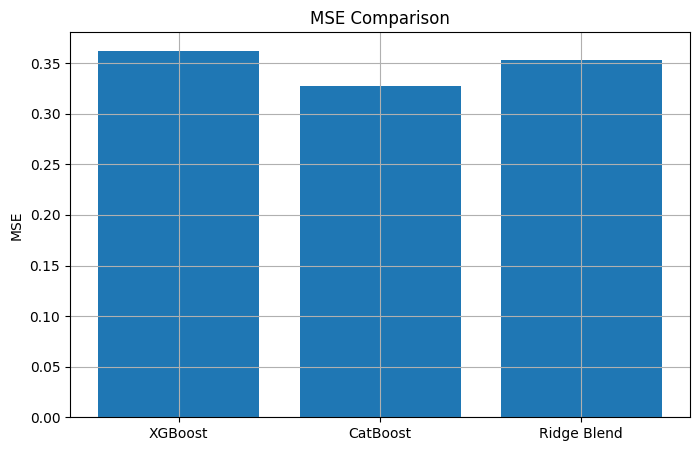

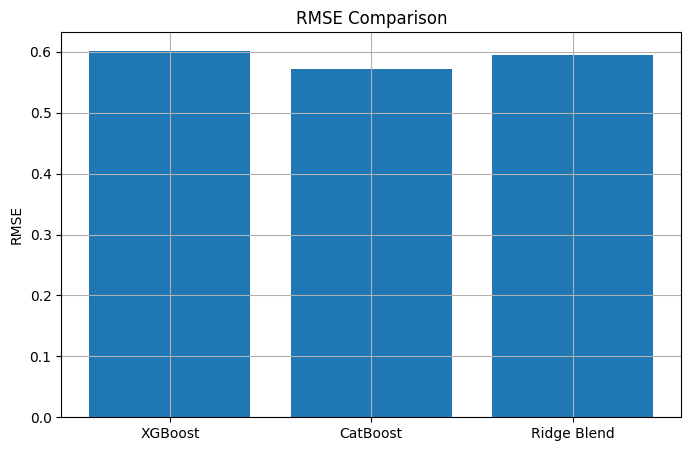

In [24]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

models = ["XGBoost", "CatBoost", "Ridge Blend"]

# ====================== METRICS ======================
r2 = [
    r2_score(y_val, pred_xgb_val),
    r2_score(y_val, pred_cat_val),
    r2_score(y_val, final_pred)
]

mae = [
    mean_absolute_error(y_val, pred_xgb_val),
    mean_absolute_error(y_val, pred_cat_val),
    mean_absolute_error(y_val, final_pred)
]

mse = [
    mean_squared_error(y_val, pred_xgb_val),
    mean_squared_error(y_val, pred_cat_val),
    mean_squared_error(y_val, final_pred)
]

rmse = [
    np.sqrt(mse[0]),
    np.sqrt(mse[1]),
    np.sqrt(mse[2])
]

# ====================== R2 Plot ======================
plt.figure(figsize=(8,5))
plt.bar(models, r2)
plt.title("R² Comparison")
plt.ylabel("R² Score")
plt.grid(True)
plt.savefig("R2_comparision.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

# ====================== MAE Plot ======================
plt.figure(figsize=(8,5))
plt.bar(models, mae)
plt.title("MAE Comparison")
plt.ylabel("MAE")
plt.grid(True)
plt.savefig("MAE_comparision.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

# ====================== MSE Plot ======================
plt.figure(figsize=(8,5))
plt.bar(models, mse)
plt.title("MSE Comparison")
plt.ylabel("MSE")
plt.grid(True)
plt.savefig("MSE_comparision.png", dpi=600, bbox_inches='tight', format='png')
plt.show()

# ====================== RMSE Plot ======================
plt.figure(figsize=(8,5))
plt.bar(models, rmse)
plt.title("RMSE Comparison")
plt.ylabel("RMSE")
plt.grid(True)
plt.savefig("RMSE_comparision.png", dpi=600, bbox_inches='tight', format='png')
plt.show()


In [33]:
import joblib

stack_info = {
    "ridge_blender": ridge,                     # final blender
    "xgb_meta": xgb,                      # meta learner 1
    "cat_meta": cat,                      # meta learner 2
    "resnet_path": "resnet_trained.h5",         # base model 1
    "mobilenet_path": "mobilenet_trained.h5",   # base model 2
    "densenet_path": "densenet_trained.h5"      # base model 3
}

joblib.dump(stack_info, "complete_stacked_ridge_bundle.pkl")

print("✔ Entire stacked model bundle saved!")

✔ Entire stacked model bundle saved!


In [34]:
from google.colab import files
files.download("complete_stacked_ridge_bundle.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>